# Analysis and Forecast of Dengue Cases in Camarines Sur

This Python notebook presents the methodology done for the time series forecasting of dengue cases in Camarines Sur.

### I. Preliminary Analysis

In [63]:
# For now, we will only import those that are necessary and import the required ones on the following sections.

import pandas as pd
import numpy as np
import os
import random
import numpy as np

Before anything else, for the sake of reproducibility, we set the seed to 42.

In [64]:
random.seed(42)

The dengue cases tracked were retrieved from DOH EPI with only the 2016 to 2020 cases used for this study. Before diving right into EDA, we first identify if the content of each file have the same column headers and data type in order to identify what possible problems may arise during data merging and feature engineering.

In [66]:
for dir in os.listdir():
    if dir[:3] == 'doh':
        df = pd.read_csv(dir)
        print(df.shape)
        print(df.info())
        print(df.head())

(6329, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6329 entries, 0 to 6328
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   loc     6329 non-null   object
 1   cases   6329 non-null   int64 
 2   deaths  6329 non-null   int64 
 3   date    6329 non-null   object
 4   Region  6329 non-null   object
 5   year    6329 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 296.8+ KB
None
     loc  cases  deaths        date                 Region  year
0  ALBAY     15       0   10/1/2016  REGION V-BICOL REGION  2016
1  ALBAY     13       0  17/01/2016  REGION V-BICOL REGION  2016
2  ALBAY      9       0  24/01/2016  REGION V-BICOL REGION  2016
3  ALBAY     14       0  31/01/2016  REGION V-BICOL REGION  2016
4  ALBAY      9       0    7/2/2016  REGION V-BICOL REGION  2016
(6636, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6636 entries, 0 to 6635
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtyp

Since there are no complications with regards to the data type and content, we proceed to merge them all into one dataset.

In [68]:
container = pd.DataFrame({})
provinces = []

for dir in os.listdir():
    if dir[:3] == 'doh':
        df = pd.read_csv(dir)
        if len(provinces) == 0:
            provinces = df['loc'].unique()
        container = pd.concat([container, df])

As a part of pre-analysis, data scraping will be done to get access to the latitudes and longitudes of each province.

In [69]:
import requests
from bs4 import BeautifulSoup as bs

qlst = {}
URL = 'https://geokeo.com/database/state/ph/'
for page in range(1, 6):
    page = requests.get(f'{URL}{page}/')
    soup = bs(page.content, 'html.parser')
    lst = soup.find_all('td')
    for i in range(0, len(lst), 6):
        state, lat, long = str(lst[i+1])[16:-5], float(str(lst[i+3])[16:-5]), float(str(lst[i+4])[16:-5])
        qlst[state.lower()] = {
            'lat': lat,
            'long': long
        }

Since the list doesn't contain cities, we prune our `provinces` list.

In [70]:
not_included = []
for i in provinces:
    if i.lower() not in qlst:
        if i == 'nueva viscaya':
            not_included.append('nueva vizcaya')
        else:
            not_included.append(i.strip().lower())

Also, based from previous observations, we need to properly map out and clean the columns.

In [71]:
mapper = {' negros oriental': 'negros oriental'}
container.replace(mapper, inplace=True)

We also remove the cities by "nullifying" their `loc` value.

In [72]:
def nullify(str):
    if str in not_included:
        return np.nan
    return str

container['loc'] = (container['loc'].str.strip()).str.lower()
container['loc'] = container['loc'].apply(nullify)
container.dropna(axis=0, inplace=True, how='any')

And from here, we map out their corresponding latitudes and longitudes.

In [73]:
def getLatitude(state):
    return qlst[state.lower()]['lat']

def getLongitude(state):
    return qlst[state.lower()]['long']

container['lat'] = container['loc'].apply(getLatitude)
container['long'] = container['loc'].apply(getLongitude)
container.head()

,loc,cases,deaths,date,Region,year,lat,long
0,albay,15,0.0,10/1/2016,REGION V-BICOL REGION,2016,13.216667,123.55
1,albay,13,0.0,17/01/2016,REGION V-BICOL REGION,2016,13.216667,123.55
2,albay,9,0.0,24/01/2016,REGION V-BICOL REGION,2016,13.216667,123.55
3,albay,14,0.0,31/01/2016,REGION V-BICOL REGION,2016,13.216667,123.55
4,albay,9,0.0,7/2/2016,REGION V-BICOL REGION,2016,13.216667,123.55


## II. Exporatory Data Analysis

Now that we're done with our preliminary cleaning for our data, we proceed to exploratory data analysis.

In [74]:
# Just like the previous step, we proceed with library imports

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Since we are dealing with a lot of provinces, I will only be doing EDA on my home province, Camarines Sur.

In [75]:
focus = container[container['loc'] == 'camarines sur']   

In [76]:
focus.head()

,loc,cases,deaths,date,Region,year,lat,long
459,camarines sur,30,0.0,10/1/2016,REGION V-BICOL REGION,2016,13.666175,123.326517
460,camarines sur,17,0.0,17/01/2016,REGION V-BICOL REGION,2016,13.666175,123.326517
461,camarines sur,14,0.0,24/01/2016,REGION V-BICOL REGION,2016,13.666175,123.326517
462,camarines sur,20,0.0,31/01/2016,REGION V-BICOL REGION,2016,13.666175,123.326517
463,camarines sur,13,0.0,7/2/2016,REGION V-BICOL REGION,2016,13.666175,123.326517


Since the date is formatted differently (dd/mm/yyyy), we standardize it as follows.

In [77]:
focus['date'] = pd.to_datetime(focus['date'], format='%d/%m/%Y')

focus = focus.set_index('date')

focus.describe()

,cases,deaths,year,lat,long
count,259.000000,259.000000,259.000000,2.590000e+02,2.590000e+02
mean,30.532819,0.281853,2018.000000,1.366617e+01,1.233265e+02
std,40.043507,0.611342,1.414214,3.559592e-15,1.423837e-14
min,0.000000,0.000000,2016.000000,1.366617e+01,1.233265e+02
25%,8.000000,0.000000,2017.000000,1.366617e+01,1.233265e+02
50%,18.000000,0.000000,2018.000000,1.366617e+01,1.233265e+02
75%,38.000000,0.000000,2019.000000,1.366617e+01,1.233265e+02
max,243.000000,4.000000,2020.000000,1.366617e+01,1.233265e+02


In [78]:
focus.head()

,loc,cases,deaths,Region,year,lat,long
date,,,,,,,
2016-01-10,camarines sur,30,0.0,REGION V-BICOL REGION,2016,13.666175,123.326517
2016-01-17,camarines sur,17,0.0,REGION V-BICOL REGION,2016,13.666175,123.326517
2016-01-24,camarines sur,14,0.0,REGION V-BICOL REGION,2016,13.666175,123.326517
2016-01-31,camarines sur,20,0.0,REGION V-BICOL REGION,2016,13.666175,123.326517
2016-02-07,camarines sur,13,0.0,REGION V-BICOL REGION,2016,13.666175,123.326517


Since we're done with necessary standardizations and preprocessing, we proceed to the analysis. First off, we create a time plot on the number of cases in Camarines Sur.

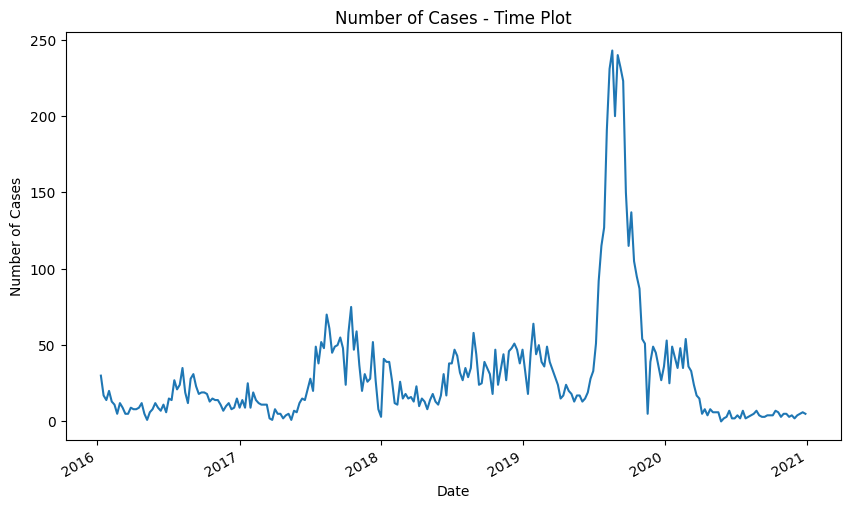

In [79]:
plt.figure(figsize=(10,6))
focus['cases'].plot(title='Number of Cases - Time Plot')
plt.ylabel('Number of Cases')
plt.xlabel('Date')
plt.show()

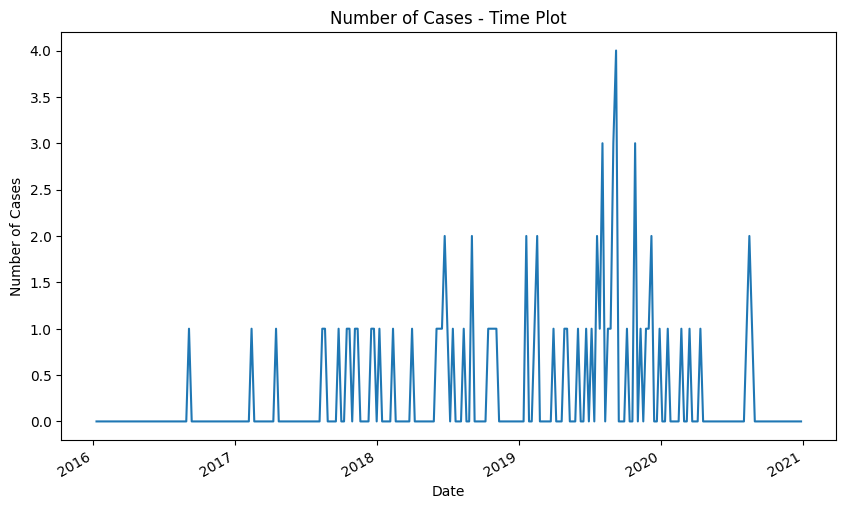

In [80]:
plt.figure(figsize=(10,6))
focus['deaths'].plot(title='Number of Cases - Time Plot')
plt.ylabel('Number of Cases')
plt.xlabel('Date')
plt.show()

From here, since the dataset we're dealing is primarily using a weekly dataset, we can see that the number of cases is pretty stable except for the spike before 2020. With regards to seasonality, there's nothing much we can tell for now.

Moving on, we proceed to preprocess additional information based from the available data.

In [27]:
focus['year'] = focus.index.year
focus['month'] = focus.index.month
focus.reset_index(inplace=True)
focus['week'] = focus['date'].dt.isocalendar().week
focus['day'] = focus['date'].dt.dayofweek
focus['day_str'] = focus['date'].dt.strftime('%a')
focus['year_month'] = focus['date'].dt.strftime('%Y_%m')
focus.set_index('date', inplace=True)

In [28]:
focus.head()

,loc,cases,deaths,Region,year,lat,long,month,week,day,day_str,year_month
date,,,,,,,,,,,,
2016-01-10,camarines sur,30,0.0,REGION V-BICOL REGION,2016,13.666175,123.326517,1,1,6,Sun,2016_01
2016-01-17,camarines sur,17,0.0,REGION V-BICOL REGION,2016,13.666175,123.326517,1,2,6,Sun,2016_01
2016-01-24,camarines sur,14,0.0,REGION V-BICOL REGION,2016,13.666175,123.326517,1,3,6,Sun,2016_01
2016-01-31,camarines sur,20,0.0,REGION V-BICOL REGION,2016,13.666175,123.326517,1,4,6,Sun,2016_01
2016-02-07,camarines sur,13,0.0,REGION V-BICOL REGION,2016,13.666175,123.326517,2,5,6,Sun,2016_02


From here, we create a time plot showcasing the number of cases per month in each year.

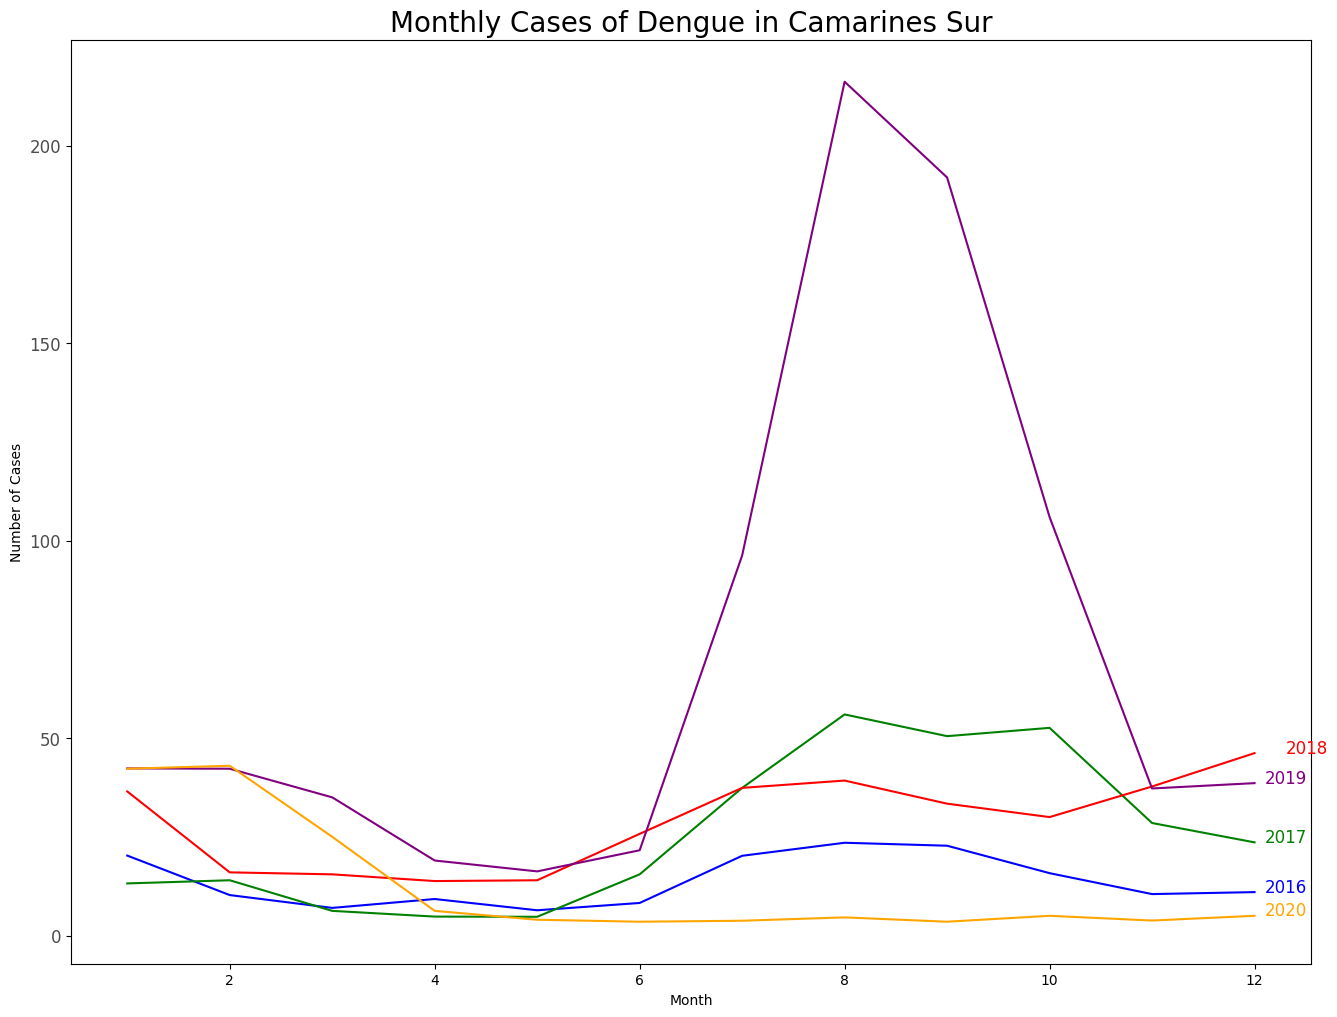

In [29]:
df_plot = focus[['month', 'year', 'cases']].dropna().groupby(['month', 'year']).mean()[['cases']].reset_index()
years = df_plot['year'].unique()
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'brown', 'black']

plt.figure(figsize=(16,12))
for i, y in enumerate(years):
    if i < len(colors):
        plt.plot('month', 'cases', data=df_plot[df_plot['year'] == y], color=colors[i], label=y)
        if y == 2018:
            plt.text(df_plot.loc[df_plot.year==y, :].shape[0]+0.3, df_plot.loc[df_plot.year==y, 'cases'][-1:].values[0], y, fontsize=12, color=colors[i])
        else:
            plt.text(df_plot.loc[df_plot.year==y, :].shape[0]+0.1, df_plot.loc[df_plot.year==y, 'cases'][-1:].values[0], y, fontsize=12, color=colors[i])

plt.gca().set(ylabel= 'PJME_MW', xlabel = 'Month')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Monthly Cases of Dengue in Camarines Sur", fontsize=20)
plt.ylabel('Number of Cases')
plt.xlabel('Month')
plt.show()

We also create a boxplot to determine the distribution of cases.

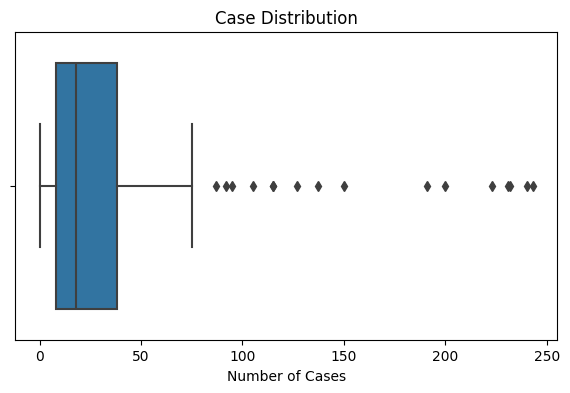

In [30]:
plt.figure(figsize=(7,4))
sns.boxplot(data=focus, x='cases')
plt.xlabel('Number of Cases')
plt.title(f'Case Distribution');

We can also do the same for the Monthly distribution.

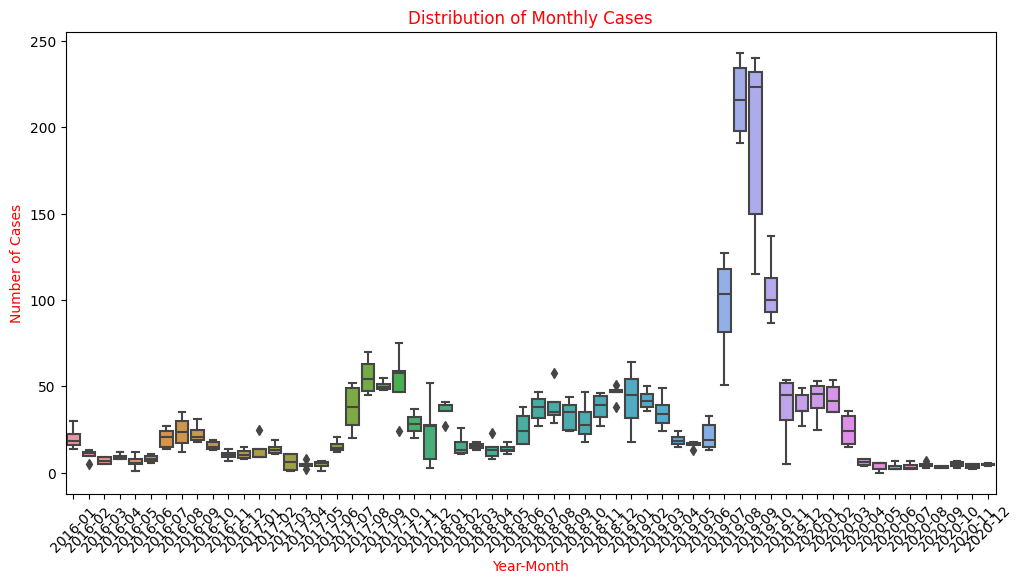

In [33]:
focus['year'] = focus.index.year
focus['month'] = focus.index.month
focus['year_month'] = focus.index.strftime('%Y-%m')

df_plot = focus[focus['year'] >= 2016]

plt.figure(figsize=(12, 6))
sns.boxplot(x='year_month', y='cases', data=df_plot)
plt.title('Distribution of Monthly Cases', color='red')
plt.xlabel('Year-Month', color ='red')
plt.ylabel('Number of Cases', color ='red')
plt.xticks(rotation=45)
plt.show()



From here on out, we will proceed to the forecasting part.

We first recheck what the contents of focus is. As we can see, we only cover Bicol Region in our dataframe so we reinclude the whole of Philippines.

In [81]:
focus.head()

,loc,cases,deaths,Region,year,lat,long
date,,,,,,,
2016-01-10,camarines sur,30,0.0,REGION V-BICOL REGION,2016,13.666175,123.326517
2016-01-17,camarines sur,17,0.0,REGION V-BICOL REGION,2016,13.666175,123.326517
2016-01-24,camarines sur,14,0.0,REGION V-BICOL REGION,2016,13.666175,123.326517
2016-01-31,camarines sur,20,0.0,REGION V-BICOL REGION,2016,13.666175,123.326517
2016-02-07,camarines sur,13,0.0,REGION V-BICOL REGION,2016,13.666175,123.326517


In [82]:
focus = container.copy()
focus['date'] = pd.to_datetime(focus['date'], format='%d/%m/%Y')
focus = focus.set_index('date')
focus.head()

,loc,cases,deaths,Region,year,lat,long
date,,,,,,,
2016-01-10,albay,15,0.0,REGION V-BICOL REGION,2016,13.216667,123.55
2016-01-17,albay,13,0.0,REGION V-BICOL REGION,2016,13.216667,123.55
2016-01-24,albay,9,0.0,REGION V-BICOL REGION,2016,13.216667,123.55
2016-01-31,albay,14,0.0,REGION V-BICOL REGION,2016,13.216667,123.55
2016-02-07,albay,9,0.0,REGION V-BICOL REGION,2016,13.216667,123.55


In [83]:
focus.drop(['deaths', 'Region', 'year', 'lat', 'long'], axis=1, inplace=True)

## Predictive Modeling

### XGBoost Predictor

In [44]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
import joblib

class XGBoostPredictor:
    def __init__(self):
        self.model = None
        self.location_encoder = LabelEncoder()
        self.best_params = None
        self.training_history = []
        self.mse = 10000000
        
    def prepare_data(self, data, location_column='loc', target_column='cases', test_size=0.15, val_size=0.15):
        data = data.copy()
        data[location_column] = self.location_encoder.fit_transform(data[location_column])
        
        train_size = int(len(data) * (1 - test_size - val_size))
        val_size = int(len(data) * val_size)
        
        train_data = data.iloc[:train_size]
        val_data = data.iloc[train_size:train_size+val_size]
        test_data = data.iloc[train_size+val_size:]
        
        X_train = train_data.drop(target_column, axis=1)
        y_train = train_data[target_column]
        X_val = val_data.drop(target_column, axis=1)
        y_val = val_data[target_column]
        X_test = test_data.drop(target_column, axis=1)
        y_test = test_data[target_column]
        
        return (X_train, y_train), (X_val, y_val), (X_test, y_test)
    
    def train_model(self, X_train, y_train, X_val, y_val, param_grid=None):
        if param_grid is None:
            param_grid = {
                'n_estimators': [100, 200, 500, 1000],
                'max_depth': [5, 10, 15, 20],
                'learning_rate': [0.01, 0.025, 0.05],
                'subsample': [0.7, 0.8, 0.9],
                'colsample_bytree': [0.7, 0.8, 0.9]
            }
        
        min_mse = float('inf')
        best_params = None
        
        for n in param_grid['n_estimators']:
            for depth in param_grid['max_depth']:
                for lr in param_grid['learning_rate']:
                    for subsample in param_grid['subsample']:
                        for colsample in param_grid['colsample_bytree']:
                            current_params = {
                                'objective': 'reg:squarederror',
                                'n_estimators': n,
                                'max_depth': depth,
                                'learning_rate': lr,
                                'min_child_weight': 1,
                                'gamma': 0,
                                'subsample': subsample,
                                'colsample_bytree': colsample
                            }
                            
                            model = XGBRegressor(**current_params)
                            model.fit(
                                X_train, y_train,
                                eval_set=[(X_val, y_val)],
                                verbose=False
                            )
                            
                            y_pred = model.predict(X_val)
                            mse = mean_squared_error(y_val, y_pred)
                            
                            self.training_history.append({
                                'params': current_params,
                                'mse': mse
                            })
                            
                            if mse < min_mse:
                                min_mse = mse
                                best_params = current_params
                                self.model = model
                                self.mse = min_mse
        
        self.best_params = best_params
        return min_mse
    
    def evaluate(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        results = {
            'mse': mean_squared_error(y_test, y_pred),
            'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
            'r2': r2_score(y_test, y_pred)
        }
        return results, y_pred
    
    def predict(self, X):
        return self.model.predict(X)
    
    def save_model(self, model_path='xgboost_model.json', encoder_path='location_encoder.joblib'):     
        self.model.save_model(model_path)
        joblib.dump(self.location_encoder, encoder_path)
    
    def load_model(self, model_path='xgboost_model.json', encoder_path='location_encoder.joblib'):
        self.model = XGBRegressor()
        self.model.load_model(model_path)
        self.location_encoder = joblib.load(encoder_path)

def main():
    predictor = XGBoostPredictor()
    
    (X_train, y_train), (X_val, y_val), (X_test, y_test) = predictor.prepare_data(
        focus,
        location_column='loc',
        target_column='cases'
    )
    
    param_grid = {
        'n_estimators': [100, 200, 500],
        'max_depth': [5, 10, 15],
        'learning_rate': [0.01, 0.025],
        'subsample': [0.8, 0.9],
        'colsample_bytree': [0.8, 0.9]
    }
    
    min_mse = predictor.train_model(X_train, y_train, X_val, y_val, param_grid)
    print(f"Best validation MSE: {min_mse:.2f}")
    print("Best parameters:", predictor.best_params)
    
    results, predictions = predictor.evaluate(X_test, y_test)
    print("\nTest set results:")
    for metric, value in results.items():
        print(f"{metric.upper()}: {value:.4f}")
    
    predictor.save_model()
    
    return predictor, predictions

if __name__ == "__main__":
    predictor, predictions = main()

Best validation MSE: 4383.83
Best parameters: {'objective': 'reg:squarederror', 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.01, 'min_child_weight': 1, 'gamma': 0, 'subsample': 0.8, 'colsample_bytree': 0.8}

Test set results:
MSE: 1644.8552
RMSE: 40.5568
R2: -0.5100


### Holt Winter Predictor

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from typing import Dict, Tuple, Optional, Any
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

class HoltWintersPredictor:
    def __init__(self, season_length: int = 12):
        self.season_length = season_length
        self.models: Dict[str, ExponentialSmoothing] = {}
        self.fits: Dict[str, Any] = {}
        self.metrics: Dict[str, Dict] = {}
        self.average_metrics: Dict[str, float] = {}
        
    def prepare_data(self, df: pd.DataFrame) -> Dict[str, pd.Series]:
        if not isinstance(df.index, pd.DatetimeIndex):
            if 'date' in df.columns:
                df['date'] = pd.to_datetime(df['date'])
                df.set_index('date', inplace=True)
            else:
                raise ValueError("DataFrame must have either a datetime index or a 'date' column")
        
        location_series = {}
        for location in df['loc'].unique():
            location_data = df[df['loc'] == location]['cases']
            if not isinstance(location_data.index, pd.DatetimeIndex):
                location_data.index = pd.to_datetime(location_data.index)
            location_series[location] = location_data
            
        return location_series
        
    def train_models(self, 
                    data: Dict[str, pd.Series],
                    trend: str = 'add',
                    seasonal: str = 'add',
                    damped_trend: bool = False) -> None:
        self.metrics.clear()
        metric_sums = {'mse': 0, 'rmse': 0, 'mae': 0, 'mape': 0}
        valid_locations = 0

        for location, series in data.items():
            try:
                if not isinstance(series.index, pd.DatetimeIndex):
                    series.index = pd.to_datetime(series.index)
                
                model = ExponentialSmoothing(
                    series,
                    trend=trend,
                    seasonal=seasonal,
                    seasonal_periods=self.season_length,
                    damped_trend=damped_trend
                )
                
                fit = model.fit()
                
                self.models[location] = model
                self.fits[location] = fit
                
                fitted_values = fit.fittedvalues
                residuals = series - fitted_values
                mse = np.mean(residuals ** 2)
                rmse = np.sqrt(mse)
                mae = np.mean(np.abs(residuals))
                mape = np.mean(np.abs(residuals / series)) * 100
                
                self.metrics[location] = {
                    'mse': mse,
                    'rmse': rmse,
                    'mae': mae,
                    'mape': mape,
                    'params': fit.params
                }

                metric_sums['mse'] += mse
                metric_sums['rmse'] += rmse
                metric_sums['mae'] += mae
                metric_sums['mape'] += mape
                valid_locations += 1
                
                print(f"\nLocation: {location}")
                print(f"MSE: {mse:.2f}")
                print(f"RMSE: {rmse:.2f}")
                print(f"MAE: {mae:.2f}")
                print(f"MAPE: {mape:.2f}%")
                
            except Exception as e:
                print(f"Error training model for location {location}: {str(e)}")
        
        if valid_locations > 0:
            self.average_metrics = {
                metric: value / valid_locations 
                for metric, value in metric_sums.items()
            }
            
            print("\nAverage Metrics Across All Locations:")
            print(f"Average MSE: {self.average_metrics['mse']:.2f}")
            print(f"Average RMSE: {self.average_metrics['rmse']:.2f}")
            print(f"Average MAE: {self.average_metrics['mae']:.2f}")
            print(f"Average MAPE: {self.average_metrics['mape']:.2f}%")
    
    def get_average_metrics(self) -> Dict[str, float]:
        return self.average_metrics
    
    def forecast(self, 
                steps: int,
                location: Optional[str] = None) -> Dict[str, pd.Series]:
        forecasts = {}
        locations = [location] if location else self.fits.keys()
        
        for loc in locations:
            if loc in self.fits:
                try:
                    last_date = self.fits[loc].fittedvalues.index[-1]
                    
                    if isinstance(last_date, pd.Timestamp):
                        future_dates = pd.date_range(
                            start=last_date + pd.DateOffset(months=1),
                            periods=steps,
                            freq='M'
                        )
                    else:
                        future_dates = pd.date_range(
                            start=last_date + timedelta(days=1),
                            periods=steps,
                            freq='D'
                        )
                    
                    forecast_values = self.fits[loc].forecast(steps)
                    
                    forecasts[loc] = pd.Series(
                        forecast_values.values,
                        index=future_dates,
                        name=f'{loc}_forecast'
                    )
                    
                except Exception as e:
                    print(f"Error forecasting for location {loc}: {str(e)}")
            else:
                print(f"No trained model found for location {loc}")
                
        return forecasts
    
    def save_models(self, path: str = 'hw_models.joblib') -> None:
        save_dict = {
            'models': self.models,
            'fits': self.fits,
            'metrics': self.metrics,
            'average_metrics': self.average_metrics,
            'season_length': self.season_length
        }
        joblib.dump(save_dict, path)
    
    def load_models(self, path: str = 'hw_models.joblib') -> None:
        saved_dict = joblib.load(path)
        self.models = saved_dict['models']
        self.fits = saved_dict['fits']
        self.metrics = saved_dict['metrics']
        self.average_metrics = saved_dict.get('average_metrics', {})
        self.season_length = saved_dict['season_length']

def main():
    predictor = HoltWintersPredictor(season_length=12)
    location_series = predictor.prepare_data(focus)
    predictor.train_models(
        location_series,
        trend='add',
        seasonal='add',
        damped_trend=True
    )
    forecasts = predictor.forecast(steps=12)
    
    avg_metrics = predictor.get_average_metrics()
    print("\nFinal Average Metrics:")
    for metric, value in avg_metrics.items():
        print(f"Average {metric.upper()}: {value:.2f}")
    
    predictor.save_models()
    
    return predictor, forecasts

if __name__ == "__main__":
    predictor, forecasts = main()


Location: albay
MSE: 30.66
RMSE: 5.54
MAE: 3.68
MAPE: inf%

Location: aurora
MSE: 104.24
RMSE: 10.21
MAE: 6.03
MAPE: inf%

Location: bataan
MSE: 244.72
RMSE: 15.64
MAE: 11.03
MAPE: inf%

Location: batanes
MSE: 30.84
RMSE: 5.55
MAE: 2.32
MAPE: inf%

Location: batangas
MSE: 1475.09
RMSE: 38.41
MAE: 21.99
MAPE: inf%

Location: bulacan
MSE: 2336.82
RMSE: 48.34
MAE: 29.77
MAPE: 36.63%

Location: cagayan
MSE: 317.37
RMSE: 17.81
MAE: 10.97
MAPE: inf%

Location: camarines norte
MSE: 28.26
RMSE: 5.32
MAE: 3.52
MAPE: inf%

Location: camarines sur
MSE: 173.84
RMSE: 13.18
MAE: 8.64
MAPE: inf%

Location: catanduanes
MSE: 23.48
RMSE: 4.85
MAE: 2.81
MAPE: inf%

Location: cavite
MSE: 2442.32
RMSE: 49.42
MAE: 28.85
MAPE: 36.22%

Location: ilocos norte
MSE: 1899.86
RMSE: 43.59
MAE: 16.73
MAPE: inf%

Location: ilocos sur
MSE: 263.47
RMSE: 16.23
MAE: 10.27
MAPE: inf%

Location: isabela
MSE: 714.60
RMSE: 26.73
MAE: 16.39
MAPE: inf%

Location: la union
MSE: 1822.53
RMSE: 42.69
MAE: 18.73
MAPE: inf%

Locati

### ARIMA Model

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from typing import Dict, Optional, Tuple, Any
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib

class ArimaPredictor:
    def __init__(self):
        self.models: Dict[str, Any] = {}
        self.fits: Dict[str, Any] = {}
        self.trends: Dict[str, Dict] = {}
        self.metrics: Dict[str, Dict] = {}
        self.decompositions: Dict[str, Any] = {}
        self.average_metrics: Dict[str, float] = {}
        
    def prepare_data(self, df: pd.DataFrame) -> Dict[str, pd.DataFrame]:

        if not isinstance(df.index, pd.DatetimeIndex):
            if 'date' in df.columns:
                df['date'] = pd.to_datetime(df['date'])
                df.set_index('date', inplace=True)
            else:
                raise ValueError("DataFrame must have either a datetime index or a 'date' column")
        
        location_data = {}
        for location in df['loc'].unique():
            loc_df = df[df['loc'] == location].copy()
            location_data[location] = loc_df
            
        return location_data

    def check_stationarity(self, series: pd.Series) -> Dict:

        result = adfuller(series)
        return {
            'test_statistic': result[0],
            'p_value': result[1],
            'is_stationary': result[1] < 0.05
        }

    def analyze_trends(self, 
                      data: Dict[str, pd.DataFrame],
                      location: Optional[str] = None) -> None:

        locations = [location] if location else data.keys()
        
        for loc in locations:
            if loc in data:
                df = data[loc]
                cases = df['cases']
                dates = df.index
                
                time_days = (dates - dates.min()).days.values.reshape(-1, 1)
                model = LinearRegression()
                model.fit(time_days, cases)
                trend_line = model.predict(time_days)
                
                r_squared = model.score(time_days, cases)
                slope = model.coef_[0]
                
                decomposition = seasonal_decompose(cases, period=12, extrapolate_trend='freq')
                self.decompositions[loc] = decomposition
                
                self.trends[loc] = {
                    'slope': slope,
                    'r_squared': r_squared,
                    'mean_cases': cases.mean(),
                    'trend_line': trend_line,
                    'stationarity': self.check_stationarity(cases)
                }

    def train_models(self, 
                    data: Dict[str, pd.DataFrame],
                    order: Tuple[int, int, int] = (1, 1, 1),
                    seasonal_order: Tuple[int, int, int, int] = (1, 1, 1, 12),
                    location: Optional[str] = None) -> None:
        print("\nTraining ARIMA Models and Computing Metrics:")
        print("-" * 50)
        
        locations = [location] if location else data.keys()
        metric_sums = {'mse': 0, 'rmse': 0, 'mae': 0, 'mape': 0, 'aic': 0, 'bic': 0}
        valid_locations = 0
        
        for loc in locations:
            if loc in data:
                try:
                    df = data[loc]
                    cases = df['cases']
                    
                    model = SARIMAX(cases,
                                  order=order,
                                  seasonal_order=seasonal_order,
                                  enforce_stationarity=False)
                    
                    fit = model.fit(disp=False)
                    
                    self.models[loc] = model
                    self.fits[loc] = fit
                    
                    predictions = fit.get_prediction(start=0)
                    predicted_values = predictions.predicted_mean
                    
                    mse = mean_squared_error(cases, predicted_values)
                    rmse = np.sqrt(mse)
                    mae = mean_absolute_error(cases, predicted_values)
                    mape = np.mean(np.abs((cases - predicted_values) / cases)) * 100
                    
                    self.metrics[loc] = {
                        'mse': mse,
                        'rmse': rmse,
                        'mae': mae,
                        'mape': mape,
                        'aic': fit.aic,
                        'bic': fit.bic
                    }
                    
                    metric_sums['mse'] += mse
                    metric_sums['rmse'] += rmse
                    metric_sums['mae'] += mae
                    metric_sums['mape'] += mape
                    metric_sums['aic'] += fit.aic
                    metric_sums['bic'] += fit.bic
                    valid_locations += 1
                    
                    print(f"\nLocation: {loc}")
                    print(f"MSE: {mse:.2f}")
                    print(f"RMSE: {rmse:.2f}")
                    print(f"MAE: {mae:.2f}")
                    print(f"MAPE: {mape:.2f}%")
                    print(f"AIC: {fit.aic:.2f}")
                    print(f"BIC: {fit.bic:.2f}")
                    
                except Exception as e:
                    print(f"Error training model for location {loc}: {str(e)}")
        
        if valid_locations > 0:
            self.average_metrics = {
                metric: value / valid_locations 
                for metric, value in metric_sums.items()
            }
            
            print("\nAverage Metrics Across All Locations:")
            print(f"Average MSE: {self.average_metrics['mse']:.2f}")
            print(f"Average RMSE: {self.average_metrics['rmse']:.2f}")
            print(f"Average MAE: {self.average_metrics['mae']:.2f}")
            print(f"Average MAPE: {self.average_metrics['mape']:.2f}%")
            print(f"Average AIC: {self.average_metrics['aic']:.2f}")
            print(f"Average BIC: {self.average_metrics['bic']:.2f}")

    def get_average_metrics(self) -> Dict[str, float]:
        return self.average_metrics

    def forecast(self, 
                steps: int,
                location: Optional[str] = None) -> Dict[str, pd.Series]:
        forecasts = {}
        locations = [location] if location else self.fits.keys()
        
        for loc in locations:
            if loc in self.fits:
                try:
                    forecast = self.fits[loc].forecast(steps)
                    forecasts[loc] = forecast
                    
                except Exception as e:
                    print(f"Error forecasting for location {loc}: {str(e)}")
            else:
                print(f"No trained model found for location {loc}")
                
        return forecasts

    def save_models(self, path: str = 'arima_models.joblib') -> None:
        save_dict = {
            'models': self.models,
            'fits': self.fits,
            'trends': self.trends,
            'metrics': self.metrics,
            'decompositions': self.decompositions,
            'average_metrics': self.average_metrics
        }
        joblib.dump(save_dict, path)
    
    def load_models(self, path: str = 'arima_models.joblib') -> None:
        saved_dict = joblib.load(path)
        self.models = saved_dict['models']
        self.fits = saved_dict['fits']
        self.trends = saved_dict['trends']
        self.metrics = saved_dict['metrics']
        self.decompositions = saved_dict['decompositions']
        self.average_metrics = saved_dict.get('average_metrics', {})

def main(df: pd.DataFrame, location: Optional[str] = None) -> Tuple[ArimaPredictor, Dict[str, pd.Series]]:

    predictor = ArimaPredictor()
    location_data = predictor.prepare_data(df)
    predictor.analyze_trends(location_data, location)
    
    predictor.train_models(
        location_data,
        order=(1, 1, 1),
        seasonal_order=(1, 1, 1, 12),
        location=location
    )
    
    avg_metrics = predictor.get_average_metrics()
    print("\nFinal Average Metrics:")
    for metric, value in avg_metrics.items():
        if metric == 'mape':
            print(f"Average {metric.upper()}: {value:.2f}%")
        else:
            print(f"Average {metric.upper()}: {value:.2f}")
    
    forecasts = predictor.forecast(steps=12, location=location)
    predictor.save_models()
    
    return predictor, forecasts

if __name__ == "__main__":
    predictor, forecasts = main(focus)


Training ARIMA Models and Computing Metrics:
--------------------------------------------------

Location: albay
MSE: 36.63
RMSE: 6.05
MAE: 4.19
MAPE: inf%
AIC: 1507.42
BIC: 1524.66

Location: aurora
MSE: 128.16
RMSE: 11.32
MAE: 7.28
MAPE: inf%
AIC: 1787.24
BIC: 1804.47

Location: bataan
MSE: 338.50
RMSE: 18.40
MAE: 12.94
MAPE: inf%
AIC: 1990.61
BIC: 2007.85

Location: batanes
MSE: 34.29
RMSE: 5.86
MAE: 2.34
MAPE: inf%
AIC: 1524.73
BIC: 1541.96

Location: batangas
MSE: 1605.76
RMSE: 40.07
MAE: 23.47
MAPE: inf%
AIC: 2397.22
BIC: 2414.46

Location: bulacan
MSE: 2533.49
RMSE: 50.33
MAE: 31.92
MAPE: 43.27%
AIC: 2507.60
BIC: 2524.84

Location: cagayan
MSE: 367.93
RMSE: 19.18
MAE: 11.77
MAPE: inf%
AIC: 2059.41
BIC: 2076.64

Location: camarines norte
MSE: 32.02
RMSE: 5.66
MAE: 3.79
MAPE: inf%
AIC: 1493.93
BIC: 1511.17

Location: camarines sur
MSE: 208.71
RMSE: 14.45
MAE: 9.77
MAPE: inf%
AIC: 1926.36
BIC: 1943.60

Location: catanduanes
MSE: 25.84
RMSE: 5.08
MAE: 2.96
MAPE: inf%
AIC: 1451.53
B

### LSTM Model

Since the LSTM model takes a lot of time to learn the dataset, I've limited the model to only take account Region V as the target.

In [55]:
focus = focus[focus['loc'].isin(['albay', 'camarines sur', 'camarines norte', 'catanduanes', 'masbate', 'sorsogon'])]

Starting Grid Search with Cross Validation...
Total combinations to try: 96
13/13 [==============================] - 0s 2ms/step

Combination 1/96:
Params: seq_length=12, n_units=32, n_layers=1, dropout=0.1, lr=0.001, batch_size=16
Mean RMSE: 9.98 (±2.81)
13/13 [==============================] - 0s 1ms/step

Combination 2/96:
Params: seq_length=12, n_units=32, n_layers=1, dropout=0.1, lr=0.001, batch_size=32
Mean RMSE: 11.68 (±5.74)
13/13 [==============================] - 0s 1ms/step

Combination 3/96:
Params: seq_length=12, n_units=32, n_layers=1, dropout=0.1, lr=0.01, batch_size=16
Mean RMSE: 12.43 (±4.32)
13/13 [==============================] - 0s 2ms/step

Combination 4/96:
Params: seq_length=12, n_units=32, n_layers=1, dropout=0.1, lr=0.01, batch_size=32
Mean RMSE: 10.52 (±3.26)
13/13 [==============================] - 0s 2ms/step

Combination 5/96:
Params: seq_length=12, n_units=32, n_layers=1, dropout=0.2, lr=0.001, batch_size=16
Mean RMSE: 10.88 (±4.13)
13/13 [===============

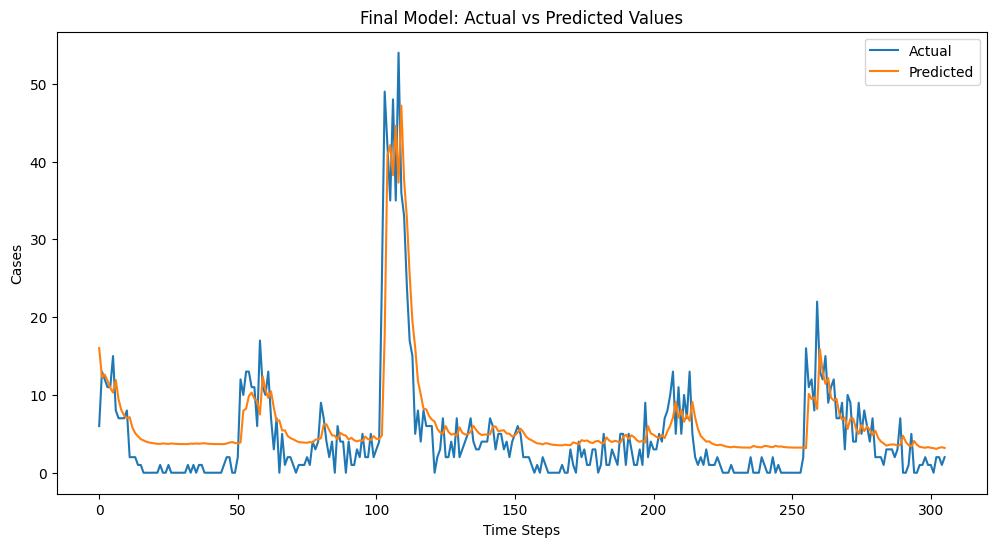


Final Model Performance:
RMSE: 4.19
MAE: 3.07


In [56]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate
from tensorflow.keras.models import Model
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import math
import itertools
from sklearn.model_selection import TimeSeriesSplit

label_encoder = LabelEncoder()
location_encoded = label_encoder.fit_transform(focus['loc'])
n_locations = len(label_encoder.classes_)

cases_array = focus['cases'].values.reshape(-1, 1)

cases_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_cases = cases_scaler.fit_transform(cases_array)

def create_sequences_with_location(cases_data, location_data, seq_length):
    """Create sequences including location information"""
    X_cases = []
    X_location = []
    y = []
    
    for i in range(len(cases_data) - seq_length):
        X_cases.append(cases_data[i:i + seq_length])
        X_location.append(location_data[i + seq_length])
        y.append(cases_data[i + seq_length])
    
    return np.array(X_cases), np.array(X_location), np.array(y)

def build_model_with_location(seq_length, n_units, n_layers, dropout_rate, learning_rate, n_locations):
    time_series_input = Input(shape=(seq_length, 1), name='time_series_input')
    location_input = Input(shape=(1,), name='location_input')
    
    if n_layers == 1:
        lstm_out = LSTM(n_units, activation='relu')(time_series_input)
    else:
        x = LSTM(n_units, activation='relu', return_sequences=True)(time_series_input)
        x = Dropout(dropout_rate)(x)
        
        for i in range(n_layers - 2):
            x = LSTM(n_units, activation='relu', return_sequences=True)(x)
            x = Dropout(dropout_rate)(x)
            
        lstm_out = LSTM(n_units, activation='relu')(x)
    
    lstm_out = Dropout(dropout_rate)(lstm_out)
    
    location_embedding = Dense(8, activation='relu')(location_input)
    
    combined = Concatenate()([lstm_out, location_embedding])
    
    x = Dense(16, activation='relu')(combined)
    output = Dense(1)(x)
    
    model = Model(inputs=[time_series_input, location_input], outputs=output)
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

param_grid = {
    'seq_length': [12, 24],
    'n_units': [32, 50, 64],
    'n_layers': [1, 2],
    'dropout_rate': [0.1, 0.2],
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32]
}

X_cases, X_location, y = create_sequences_with_location(
    scaled_cases, 
    location_encoded, 
    param_grid['seq_length'][0]
)

train_size = int(len(X_cases) * 0.8)
X_cases_train = X_cases[:train_size]
X_cases_test = X_cases[train_size:]
X_location_train = X_location[:train_size]
X_location_test = X_location[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

param_combinations = list(itertools.product(*param_grid.values()))
best_score = float('inf')
best_params = None
best_model = None
results = []

n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

print("Starting Grid Search with Cross Validation...")
print(f"Total combinations to try: {len(param_combinations)}")

for i, params in enumerate(param_combinations):
    seq_length, n_units, n_layers, dropout_rate, learning_rate, batch_size = params
    
    X_cases, X_location, y = create_sequences_with_location(scaled_cases, location_encoded, seq_length)
    
    cv_scores = []
    
    for train_idx, val_idx in tscv.split(X_cases):
        X_cases_fold_train, X_cases_fold_val = X_cases[train_idx], X_cases[val_idx]
        X_location_fold_train = X_location[train_idx]
        X_location_fold_val = X_location[val_idx]
        y_fold_train, y_fold_val = y[train_idx], y[val_idx]
        
        model = build_model_with_location(
            seq_length, n_units, n_layers, dropout_rate, learning_rate, n_locations
        )
        
        history = model.fit(
            [X_cases_fold_train, X_location_fold_train], y_fold_train,
            epochs=50,
            batch_size=batch_size,
            validation_data=([X_cases_fold_val, X_location_fold_val], y_fold_val),
            verbose=0
        )
        
        val_pred = model.predict([X_cases_fold_val, X_location_fold_val])
        val_pred = cases_scaler.inverse_transform(val_pred)
        val_true = cases_scaler.inverse_transform(y_fold_val.reshape(-1, 1))
        rmse = np.sqrt(mean_squared_error(val_true, val_pred))
        cv_scores.append(rmse)
    
    mean_rmse = np.mean(cv_scores)
    std_rmse = np.std(cv_scores)
    
    results.append({
        'params': params,
        'mean_rmse': mean_rmse,
        'std_rmse': std_rmse
    })
    
    print(f"\nCombination {i+1}/{len(param_combinations)}:")
    print(f"Params: seq_length={seq_length}, n_units={n_units}, n_layers={n_layers}, "
          f"dropout={dropout_rate}, lr={learning_rate}, batch_size={batch_size}")
    print(f"Mean RMSE: {mean_rmse:.2f} (±{std_rmse:.2f})")
    
    if mean_rmse < best_score:
        best_score = mean_rmse
        best_params = params
        best_model = model

seq_length, n_units, n_layers, dropout_rate, learning_rate, batch_size = best_params
X_cases, X_location, y = create_sequences_with_location(scaled_cases, location_encoded, seq_length)

train_size = int(len(X_cases) * 0.8)
X_cases_train = X_cases[:train_size]
X_cases_test = X_cases[train_size:]
X_location_train = X_location[:train_size]
X_location_test = X_location[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

final_model = build_model_with_location(
    seq_length, n_units, n_layers, dropout_rate, learning_rate, n_locations
)

final_history = final_model.fit(
    [X_cases_train, X_location_train], y_train,
    epochs=50,
    batch_size=batch_size,
    validation_data=([X_cases_test, X_location_test], y_test),
    verbose=1
)

predictions = final_model.predict([X_cases_test, X_location_test])
predictions = cases_scaler.inverse_transform(predictions)
actual_values = cases_scaler.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(actual_values, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Final Model: Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Cases')
plt.legend()
plt.show()

final_rmse = np.sqrt(mean_squared_error(actual_values, predictions))
final_mae = mean_absolute_error(actual_values, predictions)

print("\nFinal Model Performance:")
print(f"RMSE: {final_rmse:.2f}")
print(f"MAE: {final_mae:.2f}")

In [58]:
final_model.save('lstm_model.h5')

joblib.dump(cases_scaler, 'scaler_encoder.save')
joblib.dump(label_encoder, 'location_encoder.save')

import json
model_params = {
    'seq_length': seq_length,
    'n_units': n_units,
    'n_layers': n_layers,
    'dropout_rate': dropout_rate,
    'learning_rate': learning_rate,
    'batch_size': batch_size
}

with open('model_params_with_loc.json', 'w') as f:
    json.dump(model_params, f)